## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from tensorflow.keras.initializers import Constant
import pprint

import gensim
import gensim.models

In [2]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train_data.head() 

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


 - label:1(긍정), label:0(부정)

In [4]:
len(train_data) 

150000

In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
len(test_data)

50000

In [7]:
#이번 프로젝트에서는 불필요한 id 열 모두 삭제
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [8]:
# train_data document 열과 label 열의 nunique() 개수
train_data['document'].nunique(), train_data['label'].nunique() #3,818개가 중복?

(146182, 2)

In [9]:
# test_data document 열과 label 열의 nunique() 개수
test_data['document'].nunique(), test_data['label'].nunique() #843개가 중복?

(49157, 2)

In [10]:
# train_data document 중복 제거하고 label에 따른 데이터 수 확인
train_data.drop_duplicates(subset=['document'], inplace=True)
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [11]:
#train_data 결측치 개수 확인
print(train_data.isnull().sum()) #1개

document    1
label       0
dtype: int64


In [12]:
#train_data 결측치 데이터 확인
train_data.loc[train_data.document.isnull()] # NaN

,document,label
25857,NaN,1


In [13]:
# test_data document 중복 제거하고 label에 따른 데이터 수 확인
test_data.drop_duplicates(subset=['document'], inplace=True)
print(test_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  24446
1      1  24712


In [14]:
#test_data 결측치 개수 확인
print(test_data.isnull().sum()) #1개

document    1
label       0
dtype: int64


### 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [15]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [16]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [17]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [18]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [19]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [20]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 (pre)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

### 4) 모델 구성 및 validation set 구성

#### 1.RNN 

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 15  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터) 100,200,300,16

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          150000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 768       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 150,849
Trainable params: 150,849
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


##### validation set 구성
- 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

### 5) 모델 훈련 개시

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 37s 7ms/step - loss: 0.4820 - accuracy: 0.7818 - val_loss: 0.3595 - val_accuracy: 0.8460
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3386 - accuracy: 0.8575 - val_loss: 0.3396 - val_accuracy: 0.8503
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8664 - val_loss: 0.3357 - val_accuracy: 0.8535
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3055 - accuracy: 0.8716 - val_loss: 0.3416 - val_accuracy: 0.8520
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2957 - accuracy: 0.8767 - val_loss: 0.3349 - val_accuracy: 0.8545
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2862 - accuracy: 0.8809 - val_loss: 0.3381 - val_accuracy: 0.8562
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2764 - accuracy: 0.8852 - val_loss: 0.3399 - val_accuracy: 0.8563
Epoch

##### RNN 모델 평가

In [24]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4611 - accuracy: 0.8411
[0.4610631465911865, 0.8410602807998657]


### 6) Loss, Accuracy 그래프 시각화

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


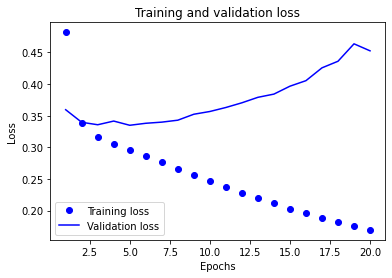

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

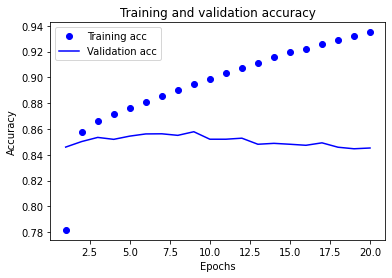

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석 

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 15)


In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']
vector

array([ 0.17052564,  0.25427365,  0.27898124, -0.26355222, -0.30833924,
        0.22256076, -0.3676682 , -0.08111304, -0.12350495,  0.31679687,
       -0.26579952, -0.13320771, -0.22496839, -0.20110254, -0.21350254],
      dtype=float32)

In [32]:
word_vectors.similar_by_word("별로")

[('졸작', 0.9823113679885864),
 ('식상', 0.9783157110214233),
 ('저급', 0.9780634045600891),
 ('조니', 0.9778622984886169),
 ('그라', 0.9753350019454956),
 ('엉성', 0.9736990332603455),
 ('포기', 0.9726274609565735),
 ('나약', 0.9725008606910706),
 ('발연기', 0.9703818559646606),
 ('병맛', 0.9702240824699402)]

### 4) 모델 구성 및 validation set 구성

#### 2. 1-D Convolution Neural Network(1-D CNN)모델

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 15  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          150000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

##### validation set 구성
- 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [34]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 22s 6ms/step - loss: 0.4649 - accuracy: 0.7660 - val_loss: 0.3437 - val_accuracy: 0.8499
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3204 - accuracy: 0.8634 - val_loss: 0.3330 - val_accuracy: 0.8565
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2844 - accuracy: 0.8819 - val_loss: 0.3315 - val_accuracy: 0.8575
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2519 - accuracy: 0.8983 - val_loss: 0.3424 - val_accuracy: 0.8555
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2172 - accuracy: 0.9153 - val_loss: 0.3627 - val_accuracy: 0.8541
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1827 - accuracy: 0.9319 - val_loss: 0.3970 - val_accuracy: 0.8497
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1518 - accuracy: 0.9456 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch

##### CNN 모델평가

In [36]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9935 - accuracy: 0.8184
[0.9934755563735962, 0.8184388875961304]


### 6) Loss, Accuracy 그래프 시각화

In [37]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


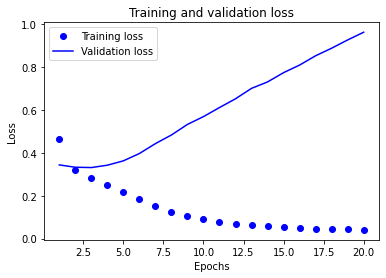

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

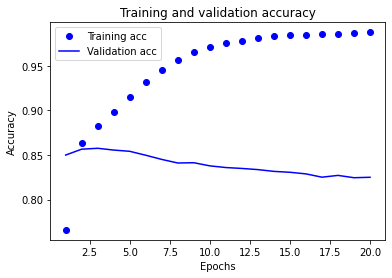

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석 

In [40]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 15)


In [41]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']
vector

array([-0.06435439,  0.14823397,  0.02648995, -0.09077704,  0.09106335,
       -0.10333567,  0.16240516, -0.17784736,  0.05863622, -0.11726608,
        0.10458647,  0.00658836, -0.23240158, -0.03091527,  0.11021147],
      dtype=float32)

In [44]:
word_vectors.similar_by_word("별로")

[('흐지부지', 0.9358434677124023),
 ('인내력', 0.9231613278388977),
 ('얼렁뚱땅', 0.9157020449638367),
 ('서세원', 0.9073120355606079),
 ('퇴화', 0.906979501247406),
 ('먼데', 0.9059614539146423),
 ('막무가내', 0.8996096849441528),
 ('시망', 0.8949223160743713),
 ('착오', 0.8934860229492188),
 ('횡설수설', 0.8905110359191895)]

### 4) 모델 구성 및 validation set 구성

##### Averaging Pooling

In [45]:
vocab_size = 10000
word_vector_dim = 15

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 15)          150000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 150,137
Trainable params: 150,137
Non-trainable params: 0
_________________________________________________________________


##### validation set 구성
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [46]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 4ms/step - loss: 0.6461 - accuracy: 0.7208 - val_loss: 0.5468 - val_accuracy: 0.7933
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.4599 - accuracy: 0.8170 - val_loss: 0.4048 - val_accuracy: 0.8324
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3800 - accuracy: 0.8418 - val_loss: 0.3667 - val_accuracy: 0.8453
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3526 - accuracy: 0.8522 - val_loss: 0.3540 - val_accuracy: 0.8476
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8575 - val_loss: 0.3491 - val_accuracy: 0.8479
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3300 - accuracy: 0.8618 - val_loss: 0.3487 - val_accuracy: 0.8481
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8646 - val_loss: 0.3453 - val_accuracy: 0.8495
Epoch 

##### 모델평가

In [48]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3690 - accuracy: 0.8421
[0.36895760893821716, 0.8421180844306946]


### 6) Loss, Accuracy 그래프 시각화

In [49]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


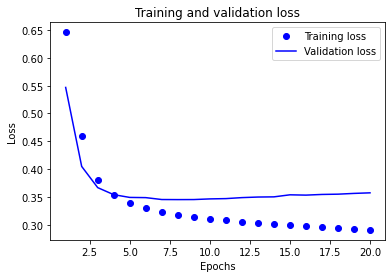

In [50]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

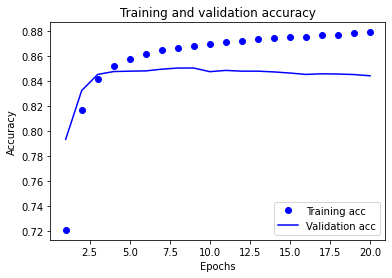

In [51]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석 

In [52]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 15)


In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [54]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']
vector

array([ 0.6654788 , -0.6757492 ,  0.6027424 ,  0.7330485 ,  0.7161756 ,
       -0.6475821 ,  0.6719442 , -0.63762856,  0.6610346 ,  0.6928776 ,
       -0.6351859 , -0.66060954, -0.5785777 ,  0.64613205,  0.60882664],
      dtype=float32)

In [57]:
word_vectors.similar_by_word("별로")

[('ㅗ', 0.9987943768501282),
 ('긴급조치', 0.9985694885253906),
 ('흑역사', 0.9985272288322449),
 ('맛없', 0.9985082149505615),
 ('핑계', 0.9984450340270996),
 ('글쎄', 0.9983675479888916),
 ('팔아먹', 0.9983595013618469),
 ('이딴', 0.9982730150222778),
 ('씁니다', 0.9982568025588989),
 ('원주율', 0.9982492923736572)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

##### 사전학습된  모델 불러오기

In [58]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [59]:
word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)
vector = word2vec.wv['별로']
print(vector)

vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word2vec.wv.key_to_index:
        embedding_matrix[i] = word2vec.wv[word]


[-0.6522194  -0.72971654  0.29973522 -1.0382856  -0.66353625  1.9211893
 -0.1113812   0.37509003 -1.0065161   2.1339107  -1.5426656  -1.4290732
 -0.7747134   1.6044024   0.02959003  0.02805945 -0.0359591  -2.6053586
  0.9430334  -1.9666804  -0.11962166  1.2537891  -0.07399909 -0.6743211
 -2.896741   -0.8409561   2.1960537  -1.4603271   0.800693   -0.50883776
  0.5734687   1.2452401  -1.1896318   0.92532426 -0.7766696  -0.21252178
  0.44364637  1.7023529  -1.2410666   0.45040238 -1.7838554   0.56376916
  1.0404649   3.5681214  -3.836213   -0.0389802  -0.9045351  -0.09502685
  0.3096315   0.07984086 -2.0829272  -0.7385968   1.3032864  -1.0671923
  0.3151587   1.6290386   0.31804296  0.81135494  0.15569398 -0.74521124
  2.3615181  -0.65269804 -1.242174   -0.9375803  -1.4413465  -0.73050594
 -0.11288032  1.5170592  -2.080498   -0.8933436   1.0371559   0.59798044
 -1.4221961  -0.12629856 -2.2256906  -1.4001553   0.70335877  0.68809146
 -0.5927846  -2.1977966   0.4621467  -0.73917115 -0.4838

In [60]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,007,633
Trainable params: 1,007,633
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
36/36 [==============================] - 2s 27ms/step - loss: 0.6732 - accuracy: 0.5825 - val_loss: 0.6447 - val_accuracy: 0.6419
Epoch 2/20
36/36 [==============================] - 1s 15ms/step - loss: 0.6026 - accuracy: 0.6880 - val_loss: 0.5386 - val_accuracy: 0.7381
Epoch 3/20
36/36 [==============================] - 1s 16ms/step - loss: 0.4991 - accuracy: 0.7632 - val_loss: 0.4561 - val_accuracy: 0.7881
Epoch 4/20
36/36 [==============================] - 1s 16ms/step - loss: 0.4401 - accuracy: 0.8002 - val_loss: 0.4097 - val_accuracy: 0.8170
Epoch 5/20
36/36 [==============================] - 1s 16ms/step - loss: 0.4025 - accuracy: 0.8219 - val_loss: 0.3780 - val_accuracy: 0.8357
Epoch 6/20
36/36 [==============================] - 1s 16ms/step - loss: 0.3760 - accuracy: 0.8355 - val_loss: 0.3549 - val_accuracy: 0.8459
Epoch 7/20
36/36 [==============================] - 1s 16ms/step - loss: 0.3568 - accuracy: 0.8462 - val_loss: 0.3425 - val_accuracy: 0.8520
Epoch 8/20
36

In [62]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3585 - accuracy: 0.8508
[0.3584861755371094, 0.8508452773094177]


##### word2vec 구현

In [63]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [64]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [65]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']
vector

array([-0.8732035 , -0.6200052 ,  0.5730036 , -1.0971154 , -0.9642829 ,
        1.6290051 ,  0.28000382,  0.07054573, -0.73689073,  1.8276232 ,
       -1.3672893 , -1.3410867 , -0.64245725,  1.2688937 ,  0.2848242 ,
       -0.27395976, -0.37489203, -2.2008593 ,  1.1773772 , -1.9377723 ,
        0.07642787,  1.5377319 ,  0.150067  , -0.38245618, -3.126486  ,
       -0.99314475,  1.9036758 , -1.778221  ,  1.0178441 , -0.35148257,
        0.8126627 ,  1.5914686 , -1.2447217 ,  0.62457275, -0.6441024 ,
        0.16546239,  0.57875127,  1.8616219 , -1.5505749 ,  0.5345461 ,
       -1.608079  ,  0.83572656,  0.78298074,  3.9145136 , -4.155671  ,
       -0.38908827, -1.0595045 , -0.3404441 ,  0.03530154,  0.15723762,
       -1.6840189 , -0.981824  ,  0.99426347, -1.0922589 ,  0.17088348,
        1.97021   ,  0.1089145 ,  0.6964668 , -0.04642231, -0.48872444,
        2.0366118 , -0.98746103, -1.5048808 , -1.2111241 , -1.586403  ,
       -1.0199174 , -0.35867572,  1.4655308 , -1.9027317 , -0.65

In [66]:
word_vectors.similar_by_word("별로")

[('그다지', 0.6358930468559265),
 ('전혀', 0.625603437423706),
 ('딱히', 0.585667073726654),
 ('꽤', 0.5627541542053223),
 ('볼일', 0.5546982288360596),
 ('확실히', 0.5284441709518433),
 ('별', 0.5262816548347473),
 ('상당히', 0.5235708951950073),
 ('차이', 0.5186886787414551),
 ('다름', 0.5020627975463867)]

## 회고

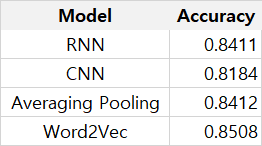

이번 프로젝트는 다양한 모델로 구현할 수 있게 사전에 설명이 충분했다고 느껴졌다. 성능 관련해서는 이제 기본 절차는 낯설지 않아서 원활하게 진행할 수 있었다. 역시 Accuracy가 낮을수록 similar_word_vector는 관련 없는 단어가 출력되었다. 반면에, 높을수록 단어도 연관이 있고 추정할 수 있는 단어들이어서 바로 확인할 수 있었다. 역시 나는 숫자상으로 표현될수록 확신을 두고 여러 가지 시도를 해보는 것 같다.
아직 Word2vec 관련해서는 마스터하지 못했지만, 이론적으로는 어렵지 않았고 다른 공유 코드를 보면서 지식을 넓혀야겠다.

https://ceuity.tistory.com/11

https://www.unicode.org/charts/PDF/UAC00.pdf

https://github.com/yenaryu/AI/blob/main/%5BE-06%5Dmovie%20reivew%20sentiment.ipynb

https://stats.stackexchange.com/questions/335793/what-is-difference-between-keras-embedding-layer-and-word2vec